In [125]:
# !pip install -r requirements.txt

# 프로젝트 - Movielens 영화 SBR
이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

In [126]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [447]:
data_path = Path('/content/drive/My Drive/Aiffel Project/Recommendation_System/data/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'UTC_Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'UTC_Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.

data

,UserId,ItemId,Rating,UTC_Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [448]:
# UTC 시간을 연월일 시분초 형식으로 변환
data['Time'] = pd.to_datetime(data['UTC_Time'], unit='s')
data

,UserId,ItemId,Rating,UTC_Time,Time
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.

특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

유저(UserId)수와 영화(ItemId)수 확인

In [449]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## *문제해결 전략*

세션과는 다르게 UserId의 각 unique값의 개수는 유저수를 의미한다.

따라서 Movielens Dataset 에 Session-based recommendation 을 적용하기 위해

1. UserId를 기준으로 데이터를 그룹화한 뒤, 1개월을 기준으로 Session을 나눈다.

2. 나눈 Session에 임의의 Session_id를 부여한다.

3. 선호 영화를 추천한다는 맥락에 맞추기 위해 Rating이 3 이하인 데이터는 제거한다.

1개월을 기준으로 Session을 나눈 이유는 일반적으로 영화 평점을 메기는 일은 쇼핑하기 위해 홈페이지를 클릭하는 것과 다르다고 생각하기 때문이다. 베이스라인 모델로 영화 관람 주기를 1개월 단위로 생각하여 Session을 정의한다.

In [450]:
# Rating 값이 4 이상인 데이터만 추출
data = data[data['Rating'] > 3]
data

,UserId,ItemId,Rating,UTC_Time,Time
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
36,1,1836,5,978300172,2000-12-31 22:02:52
...,...,...,...,...,...
1000119,6040,3671,4,997454367,2001-08-10 14:39:27
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04


In [451]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575281 entries, 31 to 1000042
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   UserId    575281 non-null  int32         
 1   ItemId    575281 non-null  int32         
 2   Rating    575281 non-null  int32         
 3   UTC_Time  575281 non-null  int64         
 4   Time      575281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3), int64(1)
memory usage: 19.8 MB


In [132]:
#data.groupby('UserId')['Time'].min()

In [133]:
#data.groupby('UserId')['Time'].min()[3]

In [452]:
# Movielens 데이터를 UserId 기준으로 그룹화하고, 데이터 생성 시간 30분 단위로 독립적인 세션을 생성 - 약 1분 30초 소요
sessions = []
session_id = 0
for Id, group in data.groupby('UserId'):
    initial_time = data.groupby('UserId')['UTC_Time'].min()[Id]
    session_id += 1
    for _, row in group.iterrows():
        if (row['UTC_Time'] - initial_time) > 30 * 60:
            session_id += 1
            initial_time = row['UTC_Time']
        sessions.append(session_id)

## ㄴ 문제해결 회고 1
1. 주어진 Movielens 데이터를 UserId를 기준으로 그룹화
2. 각 그룹을 불러올 때마다 그 그룹의 첫번째 시간(오름차순 정렬이므로)을 initial_time에 저장
3. 새로운 그룹의 iteration이 시작되면 session_id 값을 +1 하여 이전 그룹의 session_id와 구분
4. 조건문으로 해당 UserId 그룹의 각 레코드의 시간차가 30분을 초과하면 session_id 값을 +1 하고 해당 레코드의 시간을 initial_time으로 최신화.
5. 위 과정을 거친 각 레코드에 해당하는 session_id를 리스트 sessions에 할당

## ㄴ 문제해결 회고 2
1. 연월일 시분초 시간으로 계산을 하면 아래 그림에 해당하는 데이터의 세션 분류가 제대로 이루어지지 않았다.

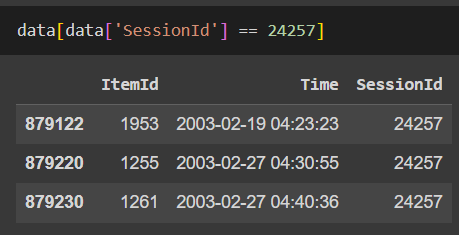

2. 따라서 UTC 시간을 기준으로 세션을 생성하는 코드를 수정하여 문제를 해결하였다.
3. 세션 분리가 제대로 안된 케이스로 인해 train 단계에서 아래와 같은 문제가 발생하였다.

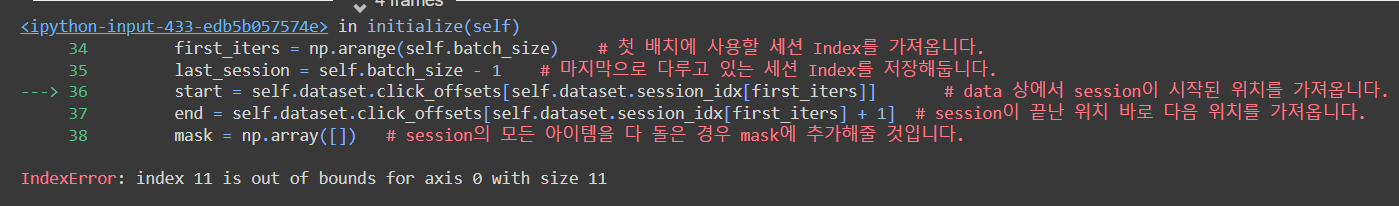

In [453]:
# SessionId 개수 확인 - UTC_Time을 기준으로 했을 때와 연월일시분초 Time을 기준으로 했을 때 세션 생성에 차이를 발견하였다.
len(set(sessions))

28221

In [454]:
data['SessionId'] = sessions
data

,UserId,ItemId,Rating,UTC_Time,Time,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,1
37,1,1022,5,978300055,2000-12-31 22:00:55,1
36,1,1836,5,978300172,2000-12-31 22:02:52,1
...,...,...,...,...,...,...
1000119,6040,3671,4,997454367,2001-08-10 14:39:27,28220
999923,6040,232,5,997454398,2001-08-10 14:39:58,28220
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,28220
999988,6040,1921,4,997454464,2001-08-10 14:41:04,28220


In [455]:
# 30분 단위 세션 생성이 잘 되었는지 확인
data[data['UserId'] == 1]

,UserId,ItemId,Rating,UTC_Time,Time,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,1
37,1,1022,5,978300055,2000-12-31 22:00:55,1
36,1,1836,5,978300172,2000-12-31 22:02:52,1
3,1,3408,4,978300275,2000-12-31 22:04:35,1
7,1,2804,5,978300719,2000-12-31 22:11:59,1
47,1,1207,4,978300719,2000-12-31 22:11:59,1
0,1,1193,5,978300760,2000-12-31 22:12:40,1
44,1,260,4,978300760,2000-12-31 22:12:40,1


In [456]:
# 30분 단위 세션 생성이 잘 되었는지 확인
data[data['UserId'] == 2]

,UserId,ItemId,Rating,UTC_Time,Time,SessionId
130,2,1198,4,978298124,2000-12-31 21:28:44,4
64,2,1210,4,978298151,2000-12-31 21:29:11,4
88,2,1293,5,978298261,2000-12-31 21:31:01,4
170,2,2943,4,978298372,2000-12-31 21:32:52,4
106,2,1225,5,978298391,2000-12-31 21:33:11,4
...,...,...,...,...,...,...
58,2,648,4,978299913,2000-12-31 21:58:33,4
84,2,368,4,978300002,2000-12-31 22:00:02,5
129,2,736,4,978300100,2000-12-31 22:01:40,5
167,2,2002,5,978300100,2000-12-31 22:01:40,5


In [457]:
# 30분 단위 세션 생성이 잘 되었는지 확인
data[data['UserId'] == 3]

,UserId,ItemId,Rating,UTC_Time,Time,SessionId
202,3,2858,4,978297039,2000-12-31 21:10:39,6
230,3,1968,4,978297068,2000-12-31 21:11:08,6
225,3,1961,4,978297095,2000-12-31 21:11:35,6
209,3,1266,5,978297396,2000-12-31 21:16:36,6
216,3,1378,5,978297419,2000-12-31 21:16:59,6
218,3,1379,4,978297419,2000-12-31 21:16:59,6
226,3,3671,5,978297419,2000-12-31 21:16:59,6
212,3,590,4,978297439,2000-12-31 21:17:19,6
201,3,260,5,978297512,2000-12-31 21:18:32,6
211,3,1196,4,978297539,2000-12-31 21:18:59,6


In [458]:
# 30분 단위 세션 생성이 잘 되었는지 확인
data[data['UserId'] == 4]

,UserId,ItemId,Rating,UTC_Time,Time,SessionId
244,4,1097,4,978293964,2000-12-31 20:19:24,7
233,4,3468,5,978294008,2000-12-31 20:20:08,7
240,4,480,4,978294008,2000-12-31 20:20:08,7
238,4,260,5,978294199,2000-12-31 20:23:19,7
242,4,1198,5,978294199,2000-12-31 20:23:19,7
248,4,1387,5,978294199,2000-12-31 20:23:19,7
239,4,2028,5,978294230,2000-12-31 20:23:50,7
247,4,2366,4,978294230,2000-12-31 20:23:50,7
250,4,1201,5,978294230,2000-12-31 20:23:50,7
251,4,2692,5,978294230,2000-12-31 20:23:50,7


In [460]:
# 세션 분류가 잘 안되었던 문제 케이스  # data[data['SessionId'] == 24257]  #data.loc[879122]
data[data['SessionId'] == 24698]

,UserId,ItemId,Rating,UTC_Time,Time,SessionId
879122,5312,1953,5,1045628603,2003-02-19 04:23:23,24698


ㄴ 세션 분류 시 2월 28일 데이터와 합쳐져 SessionId를 할당 받은 인덱스 879122 데이터 문제가 UTC_Time을 기준으로 세션 생성을 했을 때 해결되었다.

In [461]:
# 세션 분류 문제가 있을 때 직접 확인하는 코드

# pd.set_option('display.max_rows', 300)

# # Time 컬럼과 SessionId 컬럼을 기준으로 오름차순으로 정렬
# sorted_df = data.sort_values(by=['Time', 'SessionId'], ascending=True)

# # 뒷부분 200개의 레코드 출력
# last_200_records = sorted_df.tail(300)

# print(last_200_records)

# pd.reset_option('display.max_rows')

In [462]:
pd.Series(sessions).nunique()

28221

#### ㄴ 6040명 유저로부터 총 28,221개의 30분 단위 세션이 생성된 것으로 확인

세션 수와 아이템 수 확인

In [463]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(28221, 3533)

각 세션이 몇 개의 rating 데이터로 이루어져 있는지 탐색

In [464]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1        22
2        12
3        11
4        69
5         4
         ..
28217     5
28218    10
28219     1
28220    17
28221     1
Length: 28221, dtype: int64

여기서 session_length는 같은 SessionId를 공유하는 데이터 row의 개수를 의미한다.

In [465]:
session_length.median(), session_length.mean()

(9.0, 20.384855249636797)

In [466]:
session_length.min(), session_length.max()

(1, 232)

In [467]:
session_length.quantile(0.99)

117.0

In [468]:
session_length.describe()

count    28221.000000
mean        20.384855
std         26.568066
min          1.000000
25%          2.000000
50%          9.000000
75%         29.000000
max        232.000000
dtype: float64

개인적으로 30분에 30개가 넘어가는 영화 rating을 했다는 것은 이상하게 생각된다. 또한 같은 시간에 동시적으로 5개 이상의 rating을 한 데이터 또한 탐색과정에서 발견하였다. 이러한 Movielens Dataset에 대하여 조사한 결과 아래와 같은 내용을 확인하였다.

질문 : 시간이 초 단위로 구성되있는데 값은 시간에 여러개의 rating을 한 경우는 무엇인가?..

Movielens 1M Dataset은 UTC 시간대를 기준으로 구성되어 있습니다. 한 유저가 동일한 시간에 여러 영화에 대해 rating을 한 경우, 이는 일반적으로 오류라기보다는 해당 사용자가 한 번에 여러 영화에 대해 rating을 남겼다는 것을 의미합니다.

이러한 경우는 다양한 상황에서 발생할 수 있습니다:

Batch Rating: 사용자가 여러 영화에 대한 평가를 묶어서 한 번에 입력한 경우. 이는 특정 이벤트나 관련된 영화를 묶어서 한꺼번에 평가할 수 있는 상황에서 발생할 수 있습니다.

Automation: 사용자가 자동화된 프로그램이나 서비스를 통해 여러 영화에 대한 평가를 한 경우. 이는 추천 시스템이나 기타 서비스를 구현할 때 자동으로 평가를 입력하는 경우입니다.

In [469]:
long_session = session_length[session_length==232].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,UTC_Time,Time,SessionId
307124,1835,1270,5,974877069,2000-11-22 07:11:09,9371
307335,1835,3471,5,974877069,2000-11-22 07:11:09,9371
307425,1835,1175,4,974877069,2000-11-22 07:11:09,9371
307449,1835,1196,5,974877069,2000-11-22 07:11:09,9371
307797,1835,1214,5,974877069,2000-11-22 07:11:09,9371
...,...,...,...,...,...,...
307710,1835,1974,4,974878797,2000-11-22 07:39:57,9371
307248,1835,2451,4,974878819,2000-11-22 07:40:19,9371
307460,1835,1346,4,974878819,2000-11-22 07:40:19,9371
307540,1835,2517,5,974878819,2000-11-22 07:40:19,9371


In [473]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.225577
2      0.309273
3      0.360228
4      0.397753
5      0.425818
         ...   
167    0.998760
168    0.998831
169    0.998866
170    0.998937
171    0.998972
Length: 169, dtype: float64

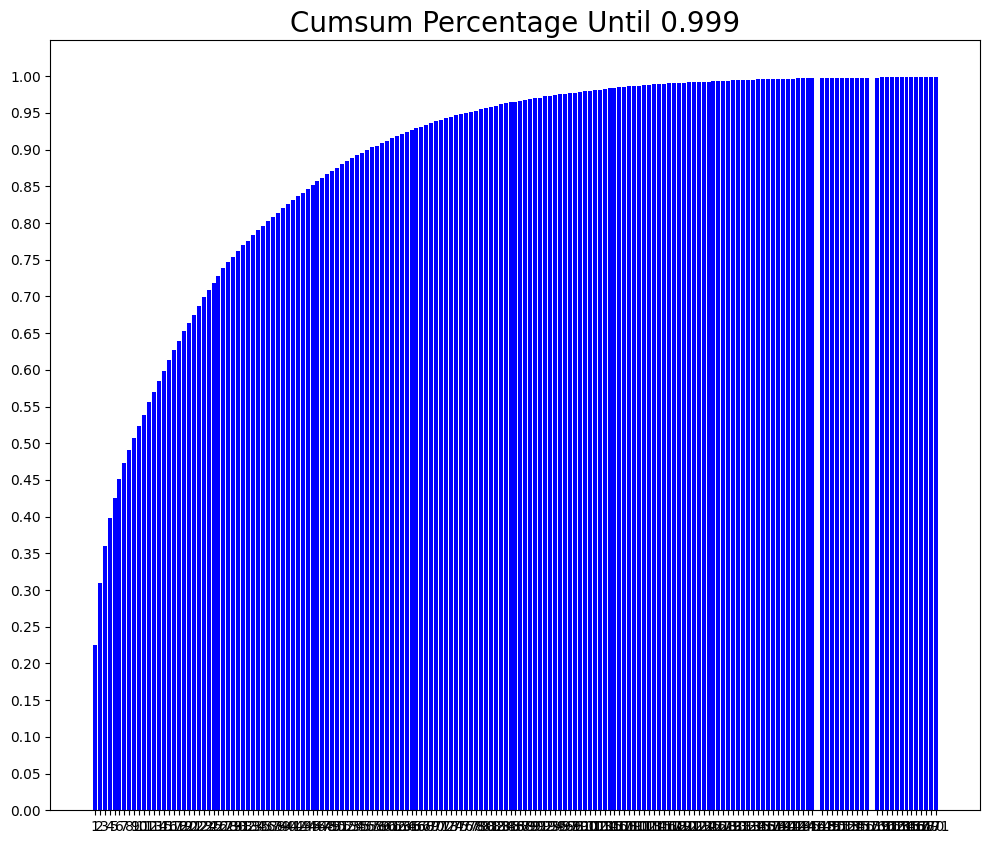

In [472]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [474]:
# 필터링 코드

# filtered_sessions = session_length[session_length<118.0].index.tolist()
# len(filtered_sessions)
# data = data[data['SessionId'].isin(filtered_sessions)]

In [356]:
# 불필요한 컬럼 삭제 코드

#data.drop(['UserId', 'Rating'], axis=1, inplace=True)

In [475]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575281 entries, 31 to 1000042
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   UserId     575281 non-null  int32         
 1   ItemId     575281 non-null  int32         
 2   Rating     575281 non-null  int32         
 3   UTC_Time   575281 non-null  int64         
 4   Time       575281 non-null  datetime64[ns]
 5   SessionId  575281 non-null  int64         
dtypes: datetime64[ns](1), int32(3), int64(2)
memory usage: 40.3 MB


### 시간(Time)에 따른 분석

Movielens 데이터의 시간 관련 정보를 확인

In [476]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


약 3년치 데이터를 확인

In [477]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않는다.

날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용한다.

약 3년치 데이터 중 최근 30일 데이터만을 활용해 모델링을 수행한다.

In [491]:
month_ago

Timestamp('2003-01-29 17:49:50')

In [492]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.
data_truncated = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다.
#data_truncated = data

### Data Cleansing
Movielens 데이터에서 SBR 태스크를 수행하기 위해 rating이 최소 2개 이상 포함된 SessionId만 남겨놓는다.

In [493]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [494]:
data_truncated = cleanse_recursive(data_truncated, shortest=2, least_click=2)
data_truncated

,UserId,ItemId,Rating,UTC_Time,Time,SessionId
58836,398,2028,4,1044565425,2003-02-06 21:03:45,1907
58804,398,2858,5,1044565486,2003-02-06 21:04:46,1907
58769,398,2599,4,1044565580,2003-02-06 21:06:20,1907
58828,398,2959,5,1044565595,2003-02-06 21:06:35,1907
58757,398,2580,4,1044565611,2003-02-06 21:06:51,1907
...,...,...,...,...,...,...
984732,5950,1261,4,1046368750,2003-02-27 17:59:10,27882
984713,5950,3911,4,1046369026,2003-02-27 18:03:46,27882
984544,5950,3481,4,1046369090,2003-02-27 18:04:50,27882
984731,5950,3948,4,1046369637,2003-02-27 18:13:57,27882


## 2.5 Train / Valid / Test split
모델 평가를 위한 Valid Set과 Test Set 생성

사용자들의 소비 패턴은 시간의 흐름에 따라 달라진다.

따라서 가장 마지막 1일 기간 동안을 Test로, 2일 전부터 1일 전 까지를 valid set으로 나눈다.

1달 전에 성능이 좋은 모델을 지금 쓰면 맞지 않을 수가 있는데, 이는 사용자들의 소비 패턴이 달라지기 때문이다.

In [495]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [496]:
tr, test = split_by_date(data_truncated, n_days=2)
tr, val = split_by_date(tr, n_days=2)

In [497]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [498]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 232
	 Sessions: 27
	 Items: 115
	 First Time : 2003-01-30 15:50:01
	 Last Time : 2003-02-22 06:40:06

* valid Set Stats Info
	 Events: 21
	 Sessions: 5
	 Items: 21
	 First Time : 2003-02-23 17:44:04
	 Last Time : 2003-02-25 16:22:32

* test Set Stats Info
	 Events: 21
	 Sessions: 4
	 Items: 21
	 First Time : 2003-02-25 19:04:24
	 Last Time : 2003-02-27 18:14:30



In [499]:
tr['Time'].sort_values()

891545   2003-01-30 15:50:01
891478   2003-01-30 15:50:15
891346   2003-01-30 15:50:51
891868   2003-01-30 15:51:38
891531   2003-01-30 15:51:54
                 ...        
882004   2003-02-22 06:36:58
882259   2003-02-22 06:37:13
882080   2003-02-22 06:38:40
882368   2003-02-22 06:40:06
882295   2003-02-22 06:40:06
Name: Time, Length: 232, dtype: datetime64[ns]

In [500]:
val['Time'].sort_values()

739500   2003-02-23 17:44:04
739396   2003-02-23 17:48:03
739332   2003-02-23 17:49:20
739452   2003-02-23 17:49:45
739504   2003-02-23 17:50:16
739552   2003-02-23 17:50:33
637543   2003-02-24 17:03:18
637511   2003-02-24 17:23:26
637572   2003-02-24 18:14:27
637520   2003-02-24 18:15:01
637561   2003-02-24 18:20:55
550222   2003-02-25 15:28:47
550067   2003-02-25 15:30:46
550566   2003-02-25 15:42:42
550582   2003-02-25 15:53:40
550562   2003-02-25 15:53:40
549941   2003-02-25 16:00:45
550242   2003-02-25 16:07:18
550623   2003-02-25 16:11:52
550427   2003-02-25 16:17:43
550218   2003-02-25 16:22:32
Name: Time, dtype: datetime64[ns]

In [501]:
test['Time'].sort_values()

550497   2003-02-25 19:04:24
549831   2003-02-25 19:04:25
549788   2003-02-25 19:06:15
261106   2003-02-26 16:12:49
261289   2003-02-26 16:13:30
772753   2003-02-27 14:03:45
772993   2003-02-27 14:10:10
772613   2003-02-27 14:22:07
984563   2003-02-27 17:44:58
984861   2003-02-27 17:45:48
984825   2003-02-27 17:45:48
984849   2003-02-27 17:50:41
984541   2003-02-27 17:51:03
984590   2003-02-27 17:53:37
984632   2003-02-27 17:54:22
984803   2003-02-27 17:54:56
984732   2003-02-27 17:59:10
984713   2003-02-27 18:03:46
984544   2003-02-27 18:04:50
984731   2003-02-27 18:13:57
984682   2003-02-27 18:14:30
Name: Time, dtype: datetime64[ns]

In [503]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [504]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 232
	 Sessions: 27
	 Items: 115
	 First Time : 2003-01-30 15:50:01
	 Last Time : 2003-02-22 06:40:06

* valid Set Stats Info
	 Events: 21
	 Sessions: 5
	 Items: 21
	 First Time : 2003-02-23 17:44:04
	 Last Time : 2003-02-25 16:22:32

* test Set Stats Info
	 Events: 21
	 Sessions: 4
	 Items: 21
	 First Time : 2003-02-25 19:04:24
	 Last Time : 2003-02-27 18:14:30



In [506]:
save_path = data_path / 'processed_movielens'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Data Pipeline
Session-Parallel Mini-Batch 구현

### 4.1 SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [530]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId #### 문제살펴보기

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.

click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.

session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [531]:
tr_dataset = SessionDataset(tr)
tr_dataset.df

,UserId,ItemId,Rating,UTC_Time,Time,SessionId,item_idx
58836,398,2028,4,1044565425,2003-02-06 21:03:45,1907,0
58804,398,2858,5,1044565486,2003-02-06 21:04:46,1907,1
58769,398,2599,4,1044565580,2003-02-06 21:06:20,1907,2
58828,398,2959,5,1044565595,2003-02-06 21:06:35,1907,3
58757,398,2580,4,1044565611,2003-02-06 21:06:51,1907,4
...,...,...,...,...,...,...,...
937383,5654,2329,4,1045161374,2003-02-13 18:36:14,26602,113
937177,5654,3408,4,1045161803,2003-02-13 18:43:23,26603,68
937292,5654,52,4,1045161956,2003-02-13 18:45:56,26603,114
937405,5654,2391,4,1045669411,2003-02-19 15:43:31,26608,61


In [532]:
tr_dataset.click_offsets

array([  0,  44,  62,  91, 112, 115, 117, 122, 125, 127, 140, 144, 146,
       151, 154, 156, 162, 164, 173, 183, 197, 200, 203, 205, 210, 228,
       230, 232], dtype=int32)

In [533]:
len(tr_dataset.click_offsets)

28

In [534]:
tr_dataset.session_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [535]:
len(tr_dataset.session_idx)

28

## 4.2 SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
__iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [556]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.

        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            #end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]
            end[idx] = self.dataset.click_offsets[min(self.dataset.session_idx[new_session] + 1, len(self.dataset.click_offsets) - 1)]
        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [557]:
tr_dataset

In [558]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,UTC_Time,Time,SessionId,item_idx
58836,398,2028,4,1044565425,2003-02-06 21:03:45,1907,0
58804,398,2858,5,1044565486,2003-02-06 21:04:46,1907,1
58769,398,2599,4,1044565580,2003-02-06 21:06:20,1907,2
58828,398,2959,5,1044565595,2003-02-06 21:06:35,1907,3
58757,398,2580,4,1044565611,2003-02-06 21:06:51,1907,4
58799,398,3578,4,1044565611,2003-02-06 21:06:51,1907,5
58698,398,3160,4,1044565658,2003-02-06 21:07:38,1907,6
58723,398,2395,5,1044565734,2003-02-06 21:08:54,1907,7
58786,398,2692,5,1044565734,2003-02-06 21:08:54,1907,8
58689,398,3081,4,1044565753,2003-02-06 21:09:13,1907,9


In [559]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.

input, output, mask의 감을 잡아 봅시다.

In [567]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 6 50 67 84]
Label Item Idx are :       [ 7 51 68 35]
Previous Masked Input Idx are []


# 4-5. Modeling
## 5.1 Evaluation Metric
모델 성능 평가를 위한 지표를 보겠습니다.
모델 성능에 대한 지표로 precision이나 recall이 있습니다.

Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.

이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.

추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.

따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.

이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.

따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다.

In [568]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 5.2 Model Architecture
스텝 3에서 소개한 모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

In [569]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [570]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [579]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=1, hsz=50, drop_rate=0.1, lr=0.0001, epochs=10, k=20)

In [580]:
model = create_model(args)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(1, 1, 115)]             0         
                                                                 
 GRU (GRU)                   [(1, 50),                 25050     
                              (1, 50)]                           
                                                                 
 dropout_14 (Dropout)        (1, 50)                   0         
                                                                 
 dense_14 (Dense)            (1, 115)                  5865      
                                                                 
Total params: 30915 (120.76 KB)
Trainable params: 30915 (120.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 5.3 Model Training
지금까지 준비한 데이터셋과 모델을 통해 학습을 진행해야 하는데요.

모델 학습에 걸리는 시간은 epoch당 30분이 넘어갑니다. 그러므로 모델 학습 직전까지만 작성해 봅시다.

배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 참고해 주세요.

In [581]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다.
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [582]:
#학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# # 학습된 모델을 불러옵니다.

# model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  62%|██████▎   | 10/16 [00:01<00:00,  9.80it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00, 11.05it/s]


	 - Recall@20 epoch 1: 0.187500
	 - MRR@20    epoch 1: 0.015690



Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  88%|████████▊ | 14/16 [00:01<00:00, 13.48it/s]

1/1 [==============================] - 0s 18ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00, 13.13it/s]


	 - Recall@20 epoch 2: 0.125000
	 - MRR@20    epoch 2: 0.012401



Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Evaluation:  62%|██████▎   | 10/16 [00:01<00:00,  9.53it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00,  9.30it/s]


	 - Recall@20 epoch 3: 0.125000
	 - MRR@20    epoch 3: 0.012401



Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  88%|████████▊ | 14/16 [00:01<00:00, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00, 12.61it/s]


	 - Recall@20 epoch 4: 0.125000
	 - MRR@20    epoch 4: 0.012401



Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


Evaluation:  88%|████████▊ | 14/16 [00:01<00:00, 13.88it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00, 13.80it/s]


	 - Recall@20 epoch 5: 0.125000
	 - MRR@20    epoch 5: 0.012054



Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Evaluation:  56%|█████▋    | 9/16 [00:01<00:00,  8.76it/s]

1/1 [==============================] - 0s 22ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00,  9.06it/s]


	 - Recall@20 epoch 6: 0.125000
	 - MRR@20    epoch 6: 0.012054



Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation:  88%|████████▊ | 14/16 [00:01<00:00, 13.51it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00, 13.50it/s]


	 - Recall@20 epoch 7: 0.125000
	 - MRR@20    epoch 7: 0.011285



Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Evaluation:  88%|████████▊ | 14/16 [00:01<00:00, 13.30it/s]

1/1 [==============================] - 0s 15ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00, 13.30it/s]


	 - Recall@20 epoch 8: 0.125000
	 - MRR@20    epoch 8: 0.010621



Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Evaluation:  62%|██████▎   | 10/16 [00:01<00:00,  9.57it/s]

1/1 [==============================] - 0s 24ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00,  9.61it/s]


	 - Recall@20 epoch 9: 0.125000
	 - MRR@20    epoch 9: 0.011979



Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  88%|████████▊ | 14/16 [00:01<00:00, 13.45it/s]

1/1 [==============================] - 0s 19ms/step


Evaluation: 100%|██████████| 16/16 [00:01<00:00, 13.39it/s]

	 - Recall@20 epoch 10: 0.125000
	 - MRR@20    epoch 10: 0.009848



# 5.4 Inference
지금까지 작성한 모델이 테스트셋에 대해서 어느 정도 성능을 내는지 검증해 봅시다.

In [583]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation:  82%|████████▏ | 14/17 [00:01<00:00, 13.20it/s]

1/1 [==============================] - 0s 16ms/step


Evaluation: 100%|██████████| 17/17 [00:01<00:00, 13.39it/s]

	 - Recall@20: 0.176471
	 - MRR@20: 0.075113

